# Install package

In [ ]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
import networkx as nx
import scipy
import pickle
import time
from cycler import cycler
import matplotlib as mpl
from matplotlib import ticker

# Environment Setup

In [ ]:
# Frequency Control Porblem Environment
class Frequency():
    def  __init__(self, Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action, coef_cost,  incidence_communication):
        self.param_gamma = 1
        self.M = M
        self.D = D
        self.Pm = Pm
        self.max_action = max_action
        self.dim_action = dim_action
        self.omega_scale = 2*np.pi# this change the unit of omega to Hz
        self.state_x = []
        self.delta_t = delta_t
        self.Penalty_action = Penalty_action
        self.state_x_transfer1 = np.vstack((np.hstack((np.identity(dim_action,dtype = np.float32),np.zeros((dim_action,dim_action),dtype = np.float32))),\
                                np.hstack((delta_t*self.omega_scale*np.identity(dim_action,dtype = np.float32),\
                                           np.identity(dim_action,dtype = np.float32)-delta_t*np.diag(D/M)))))
        self.state_x_transferF = -delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype = np.float32))*F
        self.state_x_transfer2 = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),
                                            np.identity(dim_action,dtype = np.float32)))        

        self.state_x_transfer3 = np.hstack((np.zeros((1,dim_action),dtype = np.float32),
                                            delta_t*Pm*(M**(-1))))
        self.state_x_transfer3_Pm = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),
                                               delta_t*np.diag((M**(-1)))))
        self.state_x_transfer4 = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),
                                            -delta_t*np.diag((M**(-1)))))

        self.select_add_w = np.vstack((np.zeros((dim_action,1),dtype = np.float32),\
                                        np.ones((dim_action,1),dtype = np.float32)))
        self.select_w = np.vstack((np.zeros((dim_action,dim_action),dtype = np.float32),\
                                        np.identity(dim_action,dtype = np.float32)))
        self.select_delta = np.vstack((np.identity(dim_action,dtype = np.float32),\
                                        np.zeros((dim_action,dim_action),dtype = np.float32)))
        self.diag_c  =  np.diag(coef_cost)
        self.incidence_communication = incidence_communication.astype(np.float32)

        

    def step_PI_CommEdge(self, actionP, actionI,Pm):

        cost_action, grad_action  =  self.calc_grad_action(actionI)
        action  =  actionP + actionI
        dot_s_new  =  self.state_x@self.select_w-self.CommEdgeFeedback(grad_action@self.incidence_communication)@\
                      self.incidence_communication.T@self.diag_c*0.05
        self.state_x  =  copy.deepcopy(self.state_x@self.state_x_transfer1\
              + np.sum(np.sin( np.transpose(self.state_x@self.select_delta)@np.ones((1,dim_action),dtype = np.float32)-\
                np.ones((dim_action,1),dtype = np.float32)@(self.state_x@self.select_delta))*self.state_x_transferF,axis = 1 )\
                      @self.state_x_transfer2\
              + Pm@self.state_x_transfer3_Pm\
                          +action@self.state_x_transfer4)                
        self.state_s  =  self.state_s+self.delta_t*dot_s_new/1
        loss  =  self.param_gamma*pow(self.state_x,2)@self.select_add_w 
        return self.state_s, self.state_x, loss  

    def step_PI_CommEdge_WoCost(self, actionP, actionI,Pm):

        action  =  actionP + actionI
        dot_s_new  =  self.state_x@self.select_w
        self.state_x  = copy.deepcopy(self.state_x@self.state_x_transfer1\
              + np.sum(np.sin( np.transpose(self.state_x@self.select_delta)@np.ones((1,dim_action),dtype = np.float32)-\
                np.ones((dim_action,1),dtype = np.float32)@(self.state_x@self.select_delta))*self.state_x_transferF,axis = 1 )\
                      @self.state_x_transfer2\
              + Pm@self.state_x_transfer3_Pm\
                          +action@self.state_x_transfer4)              
        self.state_s  =  self.state_s+self.delta_t*dot_s_new/1
        loss  =  self.param_gamma*pow(self.state_x,2)@self.select_add_w 
        return self.state_s, self.state_x, loss  

    def CommEdgeFeedback(self, x, func = 'linear1'):   
        if func == 'linear1':
            y = x
        return y

    def calc_grad_action(self, action):
        return 0.5*(action**4)@self.diag_c, 2*(action**3)@self.diag_c

    def set_state(self, state_input):
        self.state_x = state_input
        self.state_s  =  np.zeros((1,dim_action),dtype = np.float32)

    def reset(self):
        initial_state1 = np.random.uniform(0.0,0.3,(1,self.dim_action))
        initial_state2 = np.random.uniform(-0.03,0.03,(1,self.dim_action))
        s_concate = np.hstack((initial_state1,initial_state2)).astype(np.float32)
        self.state_x  =  s_concate
        self.state_s  =  np.zeros((1,dim_action),dtype = np.float32)
        return self.state_x

    


In [ ]:
# Simulation data load from IEEE 39-bus system
data = loadmat('IEEE_39bus_Kron_new.mat')

K_EN=data['Kron_39bus']['K']
K_EN=np.asarray(K_EN, dtype=np.float32)

H=data['Kron_39bus']['H']
H=np.asarray(H, dtype=np.float32)

Damp=data['Kron_39bus']['D']
Damp=np.asarray(Damp, dtype=np.float32)

omega_R=data['Kron_39bus']['omega_R']

A_EN=data['Kron_39bus']['A']
A_EN=np.asarray(A_EN, dtype=np.float32)

gamma=data['Kron_39bus']['gamma']
gamma=np.asarray(gamma, dtype=np.float32)

True


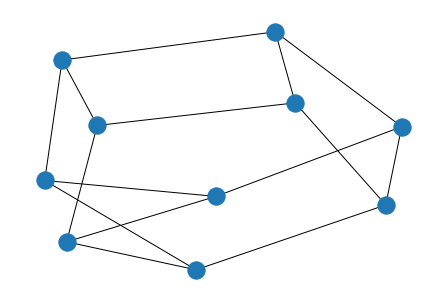

In [ ]:
dim_action = 10 #dimension of action space
dim_state = 2*dim_action #dimension of state space
G_comm = nx.random_regular_graph(3, dim_action, seed=4)
print(nx.is_connected(G_comm))
incidence_comm = scipy.sparse.csr_matrix.toarray(nx.incidence_matrix(G_comm, oriented=True))
nx.draw(G_comm)



In [ ]:
f = open('Comm_power.pckl', 'rb')
[G_comm,  incidence_comm]= pickle.load(f)
f.close()

In [ ]:

delta_t=0.01
M=H.reshape(dim_action)*2/omega_R*2*np.pi
D=np.zeros(dim_action,dtype=np.float32)
D[0]=2*590/100
D[1:8]=2*865/100
D[8:10]=2*911/100;
D=D/omega_R*2*np.pi
F=K_EN
Penalty_action=0.01*0.2
Pm=np.array([[-0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462]],dtype=np.float32)

max_action=np.array([[0.19606592, 0.2190382 , 0.22375287, 0.0975513 , 0.29071101,
        0.22091283, 0.38759459, 0.56512538, 0.24151538, 0.29821917]],dtype=np.float32)*5
equilibrium_init=np.array([[ -0.05420687, -0.07780334, -0.07351729, -0.05827823, -0.09359571,
        -0.02447385, -0.00783582,  0.00259523, -0.0162409 , -0.06477749,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.       ]],dtype=np.float32)
coef_cost = np.array([0.94162537, 1.15464676, 0.55487802, 0.71176656, 1.27476119,
       1.02529959, 1.2946042 , 1.01800112, 0.99465694, 0.73467357], dtype=np.float32)
# np.random.uniform(0.5,1.5,(dim_action))
env = Frequency(Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action, coef_cost, incidence_comm)


# RNN

## StableNN-Comm

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units_node_p
        self.action_units_node_i = action_units_node_i  
        self.internal_units = internal_units
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)
        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)

        # Matrix implementation of recover parameters in the Stacked-ReLU Neural Newrok from ancilarily variables
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)

        ## helpful matrix for vector implementation of the proportional part
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

        ## helpful matrix for vector implementation of the integral part
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        # Intermediate parameters to enforce constraints of the monotone neural network 
        ## for proportional part
        self.w_plus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name='w_plus_temp_node_p')

        self.b_plus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp_node_p')
        self.w_minus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name='w_minus_temp_node_p')

        self.b_minus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp_node_p')
        
        
        ## for integral part
        self.w_plus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.constant_initializer(5),
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp')
        self.w_minus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.constant_initializer(5),
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp')
        
        self.built = True

    def call(self, inputs, states):
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]
        #########   control action parameterization ##########
        # Monotone neural network by stacking relu function
        ## for proportional part
        w_plus_temp_node_p = tf.math.square(self.w_plus_temp0_node_p)
        b_plus_temp_node_p = tf.math.square(self.b_plus_temp0_node_p)
        w_minus_temp_node_p = tf.math.square(self.w_minus_temp0_node_p)
        b_minus_temp_node_p = tf.math.square(self.b_minus_temp0_node_p)
        w_plus_node_p = K.dot(w_plus_temp_node_p,self.w_recover)
        b_plus_node_p = K.dot(-b_plus_temp_node_p,self.b_recover)
        w_minus_node_p = K.dot(-w_minus_temp_node_p,self.w_recover)
        b_minus_node_p = K.dot(-b_minus_temp_node_p,self.b_recover)

        nonlinear_plus_node_p = K.sum(K.relu(K.dot(tf.linalg.diag( K.dot(prev_state_x,self.select_w)),self.ones_node_p)+b_plus_node_p)\
                        *w_plus_node_p,axis=2)  
        nonlinear_minus_node_p = K.sum(K.relu(-K.dot(tf.linalg.diag(K.dot(prev_state_x,self.select_w)),self.ones_node_p)+b_minus_node_p)\
                        *w_minus_node_p,axis=2)  

        action_nonconstrain0_node_p = (nonlinear_plus_node_p+nonlinear_minus_node_p)
        action_node_p = action_nonconstrain0_node_p


        ## for integral part
        w_plus_temp_node_i = tf.math.square(self.w_plus_temp0_node_i)
        b_plus_temp_node_i = tf.math.square(self.b_plus_temp0_node_i)
        w_minus_temp_node_i = tf.math.square(self.w_minus_temp0_node_i)
        b_minus_temp_node_i = tf.math.square(self.b_minus_temp0_node_i)
        w_plus_node_i = K.dot(w_plus_temp_node_i,self.w_recover)
        b_plus_node_i = K.dot(-b_plus_temp_node_i,self.b_recover)
        w_minus_node_i = K.dot(-w_minus_temp_node_i,self.w_recover)
        b_minus_node_i = K.dot(-b_minus_temp_node_i,self.b_recover)

        nonlinear_plus_node_i = K.sum(K.relu(K.dot(tf.linalg.diag( prev_state_s),self.ones_node_i)+b_plus_node_i)\
                        *w_plus_node_i,axis=2)  
        nonlinear_minus_node_i = K.sum(K.relu(-K.dot(tf.linalg.diag(prev_state_s),self.ones_node_i)+b_minus_node_i)\
                        *w_minus_node_i,axis=2)  

        action_nonconstrain0_node_i = (nonlinear_plus_node_i+nonlinear_minus_node_i)
        action_node_i = action_nonconstrain0_node_i


        ## PI control law            
        action_nonconstrain = action_node_i + action_node_p
        ## make the action between higher and lower bound
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)


        #########   calculate state transition functions  #######      
        # calculate state on s
        grad_action = 2*tf.math.pow(action_node_i,3)@self.diag_c  # quardratic
        dot_s = K.dot(prev_state_x,self.select_w)- K.dot(grad_action, self.matrix_grad_action)

        # integrate in the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)        
        return [loss0, frequency, action_node_p, action_node_i, action], [next_state]




In [ ]:
start = time.time()

episodes  = 600 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # number of neurons in each hidden layer
T = 400  #Total time period
Batch_num = 300 # number of batch in each episodes


# RNN initialization
cell = MinimalRNNCell(units,dim_action, dim_action, internal_units,env,Batch_num)
layer = RNN(cell,return_sequences = True,stateful = True)
input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
outputs = layer((input_1))
model_mono = tf.keras.models.Model([input_1], outputs)
model_mono.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x0 = np.ones((Batch_num,T,dim_action))
y0 = model_mono(x0)
global_step = tf.Variable(0, trainable = False)
learning_rate_initial = 0.05
decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 50, 0.7, staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

# Randomly generated traning set 
PrintUpdate = 1
num_gen_step = 3 # pickup three generators of have a step load change
Percent_step_change = 1
range_step_change = 1 # upper and lower bound of the step load change
Loss_record_mono = []

# Training
for i in range(0,episodes):
    initial_state = np.zeros((Batch_num,dim_action*2))+equilibrium_init
    Pm_change = np.zeros((Batch_num,T,dim_action))
    for gen_interupt in range(0, num_gen_step):
        idx_gen_deviation = np.random.randint(0, dim_action, Batch_num*Percent_step_change)
        idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
        slot_start_deviation = np.random.randint(0, T, Batch_num*Percent_step_change)  
        step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change    
        for t_interupt in range(0,T):
            Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                            = (slot_start_deviation>= t_interupt)*step_change
    layer.reset_states( np.hstack((initial_state, np.zeros((Batch_num,dim_action)))))
    with tf.GradientTape(persistent = True) as tape:
        [loss0,frequency,action0,actions, action] = model_mono(Pm_change)
        loss_action =0.5*K.sum(K.pow(action,4)@env.diag_c)/Batch_num
        loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
        loss = loss_action + loss_freq

    grads = tape.gradient(loss, model_mono.variables)
    optimizer.apply_gradients(zip(grads, model_mono.variables))  
    Loss_record_mono.append(loss)
    if i % (PrintUpdate) ==  0:
        print('episode',i, 'Loss',loss)
        print('episode',i, 'Loss_frequency',loss_freq)

end = time.time()
print(end - start)    

Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

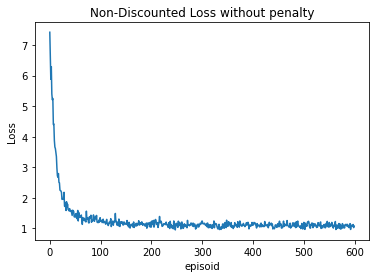

In [ ]:
plt.plot(Loss_record_mono)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

##Linear-Comm

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_linear(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units_node_p
        self.action_units_node_i = action_units_node_i  
        self.internal_units = internal_units
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)
        ## helpful matrix for vector implementation of the proportional part

        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

        ## helpful matrix for vector implementation of the integral part
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)


        super(MinimalRNNCell_linear, self).__init__(**kwargs)

    def build(self, input_shape):

        ## for proportional part
        self.k_node_p =  self.add_weight(
            shape=(self.action_units_node_p,),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2),
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='k_node_p')


        
        ## for integral part
        self.k_node_i =  self.add_weight(
            shape=(self.action_units_node_i,),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=10),
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='k_node_i')
        
        self.built = True

    def call(self, inputs, states):
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]
      

        #########   control action parameterization ##########

        action_nonconstrain0_node_p =K.dot(K.dot(prev_state_x,self.select_w), tf.linalg.diag(self.k_node_p))
        action_node_p = action_nonconstrain0_node_p

        action_nonconstrain0_node_i = K.dot(prev_state_s, tf.linalg.diag(self.k_node_i))
        action_node_i = action_nonconstrain0_node_i
        ## PI control law            

        action_nonconstrain = action_node_i + action_node_p
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # 
        # calculate state on s
        grad_action =  2*tf.math.pow(action_node_i,3)@self.diag_c # quardratic
        dot_s = K.dot(prev_state_x,self.select_w)- K.dot(grad_action, self.matrix_grad_action)

        #########   calculate state transition functions  #######      
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)        
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
start = time.time()

episodes  = 600 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # number of neurons in each hidden layer
T = 400  #Total time period
Batch_num = 300 # number of batch in each episodes


# RNN initialization
cell_linear = MinimalRNNCell_linear(units,dim_action, dim_action, internal_units,env,Batch_num)
layer_linear = RNN(cell_linear,return_sequences = True,stateful = True)
input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
outputs = layer_linear((input_1))
model_linear = tf.keras.models.Model([input_1], outputs)
model_linear.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x0 = np.ones((Batch_num,T,dim_action))
y0 = model_linear(x0)
Loss_record_linear = []

global_step = tf.Variable(0, trainable = False)
learning_rate_initial = 0.05
decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 50, 0.7, staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

PrintUpdate = 1
num_gen_step = 3
Percent_step_change = 1
range_step_change = 1
for i in range(0,episodes):
    initial_state = np.zeros((Batch_num,dim_action*2))+equilibrium_init
    Pm_change = np.zeros((Batch_num,T,dim_action))
    for gen_interupt in range(0, num_gen_step):
        idx_gen_deviation = np.random.randint(0, dim_action, Batch_num*Percent_step_change)
        idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
        slot_start_deviation = np.random.randint(0, T, Batch_num*Percent_step_change)  
        step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change    
        for t_interupt in range(0,T):
            Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                            = (slot_start_deviation>= t_interupt)*step_change
    layer_linear.reset_states( np.hstack((initial_state, np.zeros((Batch_num,dim_action)))))
    with tf.GradientTape(persistent = True) as tape:
        [loss0,frequency,action0,actions, action] = model_linear(Pm_change)
        loss_action =0.5*K.sum(K.pow(action,4)@env.diag_c)/Batch_num
        loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
        loss = loss_action + loss_freq

    grads = tape.gradient(loss, model_linear.variables)
    optimizer.apply_gradients(zip(grads, model_linear.variables))  
    Loss_record_linear.append(loss)
    if i % (PrintUpdate) ==  0:
        print('episode',i, 'Loss',loss)
        print('episode',i, 'Loss_frequency',loss_freq)

end = time.time()
print(end - start)    

Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

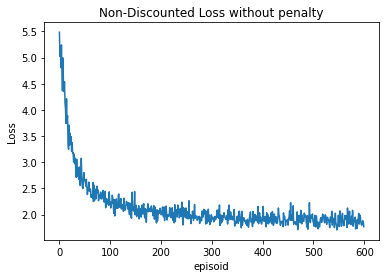

In [ ]:
plt.plot(Loss_record_linear)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

## DenseNN-Comm

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_NN(keras.layers.Layer):
    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units_node_p
        self.action_units_node_i = action_units_node_i   
        self.internal_units = internal_units
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        # self.Multiply_ones = tf.tile(tf.ones((action_units,action_units),dtype = np.float32)[None], [batchsize, 1, 1]) 
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)

        ## helpful matrix for vector implementation of the proportional part
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

        ## helpful matrix for vector implementation of the integral part
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        super(MinimalRNNCell_NN, self).__init__(**kwargs)

    def build(self, input_shape):

        ## for proportional part
        self.w_plus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='w_plus_temp_node_p')

        self.b_plus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='b_plus_temp_node_p')
        self.w_minus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='w_minus_temp_node_p')

        self.b_minus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='b_minus_temp_node_p')
        
        ## for integral part
        self.w_plus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='b_plus_temp')
        self.w_minus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer='random_normal',
            trainable=True,
            name='b_minus_temp')
        
        self.built = True

    def call(self, inputs, states):
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]


        ## for proportional part


        action_nonconstrain0_node_p = K.sum(K.relu(K.dot(tf.linalg.diag(K.dot(prev_state_x,self.select_w)),self.w_plus_temp0_node_p)\
                                         +self.b_plus_temp0_node_p)*self.w_minus_temp0_node_p+self.b_minus_temp0_node_p,axis=2)
        action_node_p = action_nonconstrain0_node_p


        ## for integral part



        action_nonconstrain0_node_i = K.sum(K.relu(K.dot(tf.linalg.diag(prev_state_s),self.w_plus_temp0_node_i)\
                                         +self.b_plus_temp0_node_i)*self.w_minus_temp0_node_i+self.b_minus_temp0_node_i,axis=2)
        action_node_i = action_nonconstrain0_node_i


        ## PI control law            
        action_nonconstrain = action_node_i + action_node_p
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # action_nonconstrain
        # 
        #########   calculate state transition functions  #######      
        # calculate state on s
        grad_action = 2*tf.math.pow(action_node_i,3)@self.diag_c  # quardratic
        dot_s = K.dot(prev_state_x,self.select_w)- K.dot(grad_action, self.matrix_grad_action)

        # integrate in the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)        
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
start = time.time()

episodes  = 600 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # number of neurons in each hidden layer
T = 400  #Total time period
Batch_num = 300 # number of batch in each episodes


# RNN initialization
cell_NN = MinimalRNNCell_NN(units,dim_action, dim_action, internal_units,env,Batch_num)
layer_NN = RNN(cell_NN,return_sequences = True,stateful = True)
input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
outputs = layer_NN((input_1))
model_NN = tf.keras.models.Model([input_1], outputs)
model_NN.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x0 = np.ones((Batch_num,T,dim_action))
y0 = model_NN(x0)
Loss_record_NN = []
Pe_rnn_record = []
global_step = tf.Variable(0, trainable = False)
learning_rate_initial = 0.0015
decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 50, 0.7, staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

PrintUpdate = 1
delta_rnn_init_bound = 0.05*0
omega_rnn_init_bound = 0.1*0 #in Hz
num_gen_step = 3
Percent_step_change = 1
range_step_change = 1
for i in range(0,episodes):

    initial_state = np.zeros((Batch_num,dim_action*2))+equilibrium_init
    Pm_change = np.zeros((Batch_num,T,dim_action))
    for gen_interupt in range(0, num_gen_step):
        idx_gen_deviation = np.random.randint(0, dim_action, Batch_num*Percent_step_change)
        idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
        slot_start_deviation = np.random.randint(0, T, Batch_num*Percent_step_change)  
        step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change    
        for t_interupt in range(0,T):
            Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                            = (slot_start_deviation>= t_interupt)*step_change
    layer_NN.reset_states( np.hstack((initial_state, np.zeros((Batch_num,dim_action)))))
    with tf.GradientTape(persistent = True) as tape:
        [loss0,frequency,action0,actions, action] = model_NN(Pm_change)
        loss_action =0.5*K.sum(K.pow(action,4)@env.diag_c)/Batch_num
        loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
        loss = loss_action + loss_freq

    grads = tape.gradient(loss, model_NN.variables)
    optimizer.apply_gradients(zip(grads, model_NN.variables))  
    Loss_record_NN.append(loss)
    if i % (PrintUpdate) ==  0:
        print('episode',i, 'Loss',loss)
        print('episode',i, 'Loss_frequency',loss_freq)

end = time.time()
print(end - start)    


Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

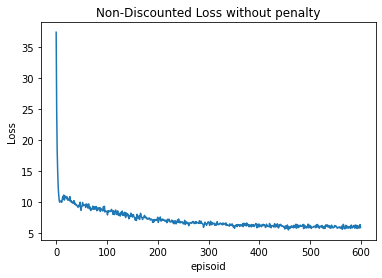

In [ ]:
plt.plot(Loss_record_NN)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

## StableNN-WoComm

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units_node_p
        self.action_units_node_i = action_units_node_i   
        self.internal_units = internal_units
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)

        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)
        # Matrix implementation of recover parameters in the Stacked-ReLU Neural Newrok from ancilarily variables
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)

        ## helpful matrix for vector implementation of the proportional part
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

        ## helpful matrix for vector implementation of the integral part
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)


        super(MinimalRNNCell_WoCost, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        # Intermediate parameters to enforce constraints of the monotone neural network 
        ## for proportional part
        self.w_plus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name='w_plus_temp_node_p')

        self.b_plus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp_node_p')
        self.w_minus_temp0_node_p =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name='w_minus_temp_node_p')

        self.b_minus_temp0_node_p = self.add_weight(
            shape=(self.action_units_node_p,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp_node_p')
        
        
        ## for integral part
        self.w_plus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.constant_initializer(5),
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp')
        self.w_minus_temp0_node_i =  self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.constant_initializer(5),
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0_node_i = self.add_weight(
            shape=(self.action_units_node_i,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.2),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp')
        
        self.built = True

    def call(self, inputs, states):
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]
        #########   control action parameterization ##########
        # Monotone neural network by stacking relu function
        ## for proportional part
        w_plus_temp_node_p = tf.math.square(self.w_plus_temp0_node_p)
        b_plus_temp_node_p = tf.math.square(self.b_plus_temp0_node_p)
        w_minus_temp_node_p = tf.math.square(self.w_minus_temp0_node_p)
        b_minus_temp_node_p = tf.math.square(self.b_minus_temp0_node_p)
        w_plus_node_p = K.dot(w_plus_temp_node_p,self.w_recover)
        b_plus_node_p = K.dot(-b_plus_temp_node_p,self.b_recover)
        w_minus_node_p = K.dot(-w_minus_temp_node_p,self.w_recover)
        b_minus_node_p = K.dot(-b_minus_temp_node_p,self.b_recover)

        nonlinear_plus_node_p = K.sum(K.relu(K.dot(tf.linalg.diag( K.dot(prev_state_x,self.select_w)),self.ones_node_p)+b_plus_node_p)\
                        *w_plus_node_p,axis=2)  
        nonlinear_minus_node_p = K.sum(K.relu(-K.dot(tf.linalg.diag(K.dot(prev_state_x,self.select_w)),self.ones_node_p)+b_minus_node_p)\
                        *w_minus_node_p,axis=2)  

        action_nonconstrain0_node_p = (nonlinear_plus_node_p+nonlinear_minus_node_p)
        action_node_p = action_nonconstrain0_node_p


        ## for integral part

        w_plus_temp_node_i = tf.math.square(self.w_plus_temp0_node_i)
        b_plus_temp_node_i = tf.math.square(self.b_plus_temp0_node_i)
        w_minus_temp_node_i = tf.math.square(self.w_minus_temp0_node_i)
        b_minus_temp_node_i = tf.math.square(self.b_minus_temp0_node_i)
        w_plus_node_i = K.dot(w_plus_temp_node_i,self.w_recover)
        b_plus_node_i = K.dot(-b_plus_temp_node_i,self.b_recover)
        w_minus_node_i = K.dot(-w_minus_temp_node_i,self.w_recover)
        b_minus_node_i = K.dot(-b_minus_temp_node_i,self.b_recover)

        nonlinear_plus_node_i = K.sum(K.relu(K.dot(tf.linalg.diag( prev_state_s),self.ones_node_i)+b_plus_node_i)\
                        *w_plus_node_i,axis=2)  
        nonlinear_minus_node_i = K.sum(K.relu(-K.dot(tf.linalg.diag(prev_state_s),self.ones_node_i)+b_minus_node_i)\
                        *w_minus_node_i,axis=2)  

        action_nonconstrain0_node_i = (nonlinear_plus_node_i+nonlinear_minus_node_i)
        action_node_i = action_nonconstrain0_node_i


        ## PI control law            
        action_nonconstrain = action_node_i + action_node_p
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # 


        #########   calculate state transition functions  #######      
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

        # integrate in the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)        
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
start = time.time()

episodes  = 600 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # number of neurons in each hidden layer
T = 400  #Total time period
Batch_num = 300 # number of batch in each episodes


# RNN initialization
cell_WoCost = MinimalRNNCell_WoCost(units,dim_action, dim_action, internal_units,env,Batch_num)
layer_WoCost = RNN(cell_WoCost,return_sequences = True,stateful = True)
input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
outputs = layer_WoCost((input_1))
model_WoCost = tf.keras.models.Model([input_1], outputs)
model_WoCost.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x0 = np.ones((Batch_num,T,dim_action))
y0 = model_WoCost(x0)
Loss_record_mono_WoCost = []

global_step = tf.Variable(0, trainable = False)
learning_rate_initial = 0.05
decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 50, 0.7, staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

PrintUpdate = 1
num_gen_step = 3
Percent_step_change = 1
range_step_change = 1
for i in range(0,episodes):
    initial_state = np.zeros((Batch_num,dim_action*2))+equilibrium_init
    Pm_change = np.zeros((Batch_num,T,dim_action))
    for gen_interupt in range(0, num_gen_step):
        idx_gen_deviation = np.random.randint(0, dim_action, Batch_num*Percent_step_change)
        idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
        slot_start_deviation = np.random.randint(0, T, Batch_num*Percent_step_change)  
        step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change    
        for t_interupt in range(0,T):
            Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                            = (slot_start_deviation>= t_interupt)*step_change

    layer_WoCost.reset_states( np.hstack((initial_state, np.zeros((Batch_num,dim_action)))))
    with tf.GradientTape(persistent = True) as tape:
        [loss0,frequency,action0,actions, action] = model_WoCost(Pm_change)
        loss_action =0.5*K.sum(K.pow(action,4)@env.diag_c)/Batch_num
        loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
        loss = loss_action + loss_freq

    grads = tape.gradient(loss, model_WoCost.variables)
    optimizer.apply_gradients(zip(grads, model_WoCost.variables))  
    Loss_record_mono_WoCost.append(loss)
    if i % (PrintUpdate) ==  0:
        print('episode',i, 'Loss',loss)
        print('episode',i, 'Loss_frequency',loss_freq)

end = time.time()
print(end - start)    

Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

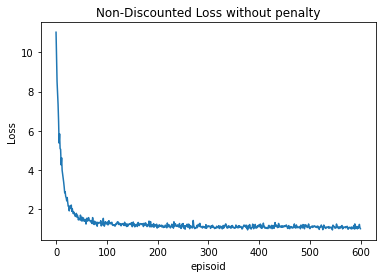

In [ ]:
plt.plot(Loss_record_mono_WoCost)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

# Actions

In [ ]:
def Action_P(state, model, env):
    
    w_plus=K.dot(tf.math.square(model.variables[0]),cell.w_recover)
    b_plus=K.dot(-tf.math.square(model.variables[1]),cell.b_recover)
    w_minus=K.dot(-tf.math.square(model.variables[2]),cell.w_recover)
    b_minus=K.dot(-tf.math.square(model.variables[3]),cell.b_recover)
    nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(state@env.select_w),cell.ones_node_p)+b_plus)\
                    *w_plus,axis=2)  
    nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(state@env.select_w),cell.ones_node_p)+b_minus)\
                    *w_minus,axis=2)  
    action_nonconstrain0= nonlinear_plus+nonlinear_minus


    return action_nonconstrain0

def Action_I(state_s, model, env):
    w_plus1=K.dot(tf.math.square(model.variables[4]),cell.w_recover)
    b_plus1=K.dot(-tf.math.square(model.variables[5]),cell.b_recover)
    w_minus1=K.dot(-tf.math.square(model.variables[6]),cell.w_recover)
    b_minus1=K.dot(-tf.math.square(model.variables[7]),cell.b_recover)
    nonlinear_plus1=K.sum(K.relu(K.dot(tf.linalg.diag(state_s),cell.ones_node_i)+b_plus1)\
                    *w_plus1,axis=2)  
    nonlinear_minus1=K.sum(K.relu(-K.dot(tf.linalg.diag(state_s),cell.ones_node_i)+b_minus1)\
                    *w_minus1,axis=2)  
    action_nonconstrain1= nonlinear_plus1+nonlinear_minus1

    return action_nonconstrain1

def Action(state_x, state_s, model, env):
    action_nonconstrain0 = Action_P(state_x, model, env)
    action_nonconstrain1 = Action_I(state_s,model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


In [ ]:
def Action_NNLinear_edge(state, model, env):
    

    action_nonconstrain0 = (state-env.eta0)*abs(model.variables[0])

    action=env.max_action_edge-np_relu(env.max_action_edge-action_nonconstrain0)\
            +np_relu(-env.max_action_edge-action_nonconstrain0)

    return action
    


def Action_NNLinear_P(state, model, env):
    

    action_nonconstrain0 = (state@env.select_w)*(model.variables[0])

    action=env.max_action-K.relu(env.max_action-action_nonconstrain0)+K.relu(-env.max_action-action_nonconstrain0)
    return action

def Action_NNLinear_I(state, model, env):

    action_nonconstrain0= state*(model.variables[1])

    action = action_nonconstrain0

    return action

def Action_NNLinear(state_x, state_s, model, env):
    action_nonconstrain0 = Action_NNLinear_P(state_x, model, env)
    action_nonconstrain1 = Action_NNLinear_I(state_s,model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1

    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


In [ ]:
def Action_DenseNN_P(state, model, env):
    

    action_nonconstrain0= K.sum(K.relu(K.dot(tf.linalg.diag(state@env.select_w),model.variables[0])+model.variables[1])*\
                  model.variables[2]+model.variables[3],axis=2)    
    return action_nonconstrain0

def Action_DenseNN_I(state_s, model, env):

    action_nonconstrain1= K.sum(K.relu(K.dot(tf.linalg.diag(state_s),model.variables[4])+model.variables[5])*\
                  model.variables[6]+model.variables[7],axis=2)
    return action_nonconstrain1

def Action_DenseNN(state_x, state_s, model, env):
    action_nonconstrain0 = Action_DenseNN_P(state_x, model, env)
    action_nonconstrain1 = Action_DenseNN_I(state_s,model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


# Plot_all

## Loss

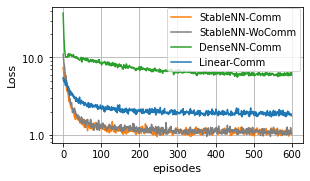

In [ ]:

fig, ax=plt.subplots(figsize=(4.5, 2.5))
labels =['StableNN-WoComm', 'StableNN-Comm','Linear-Comm','DenseNN-Comm']
normallize = 1
param_fontsize = 11
ax.plot(np.array(Loss_record_mono)/normallize, label=labels[1], color='tab:orange')
ax.plot(np.array(Loss_record_mono_WoCost)/normallize, label=labels[0], color='tab:grey')
ax.plot(np.array(Loss_record_NN)/normallize, label=labels[3], color='tab:green')
ax.plot(np.array(Loss_record_linear)/normallize, label=labels[2], color='tab:blue')

ax.set_yscale("log")
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 
ax.set_xlabel('episodes',fontsize=param_fontsize)
ax.set_ylabel('Loss',fontsize = param_fontsize)
ax.grid()
ax.legend(bbox_to_anchor=(0.46, 0.99), loc='upper left', borderaxespad=0., prop={"size":10})


## dyn_full

### StableNN-Comm

tf.Tensor([[1.4474068]], shape=(1, 1), dtype=float32)


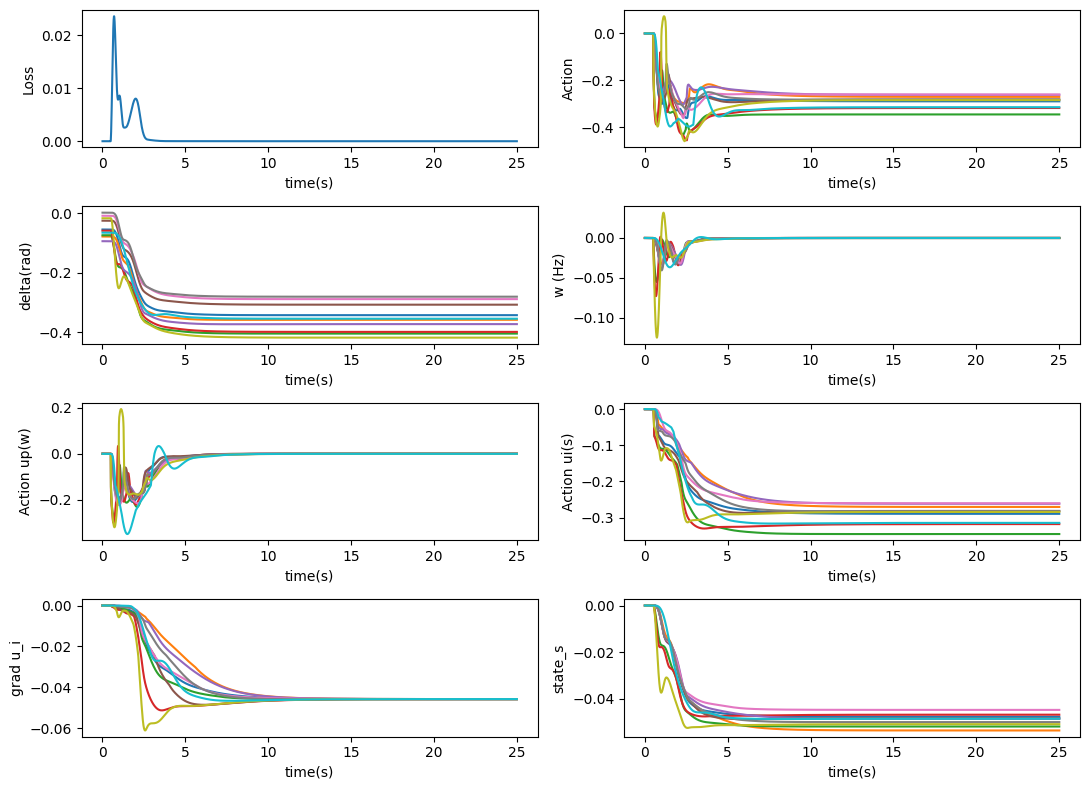

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

init_state=equilibrium_init

# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=2500
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
Pm2[0][gen_id]=-1
action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):

    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()

    u, up, ui = Action(x, action_s, layer, env)

    action_s, next_x, r= env.step_PI_CommEdge(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))


print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:dim_action])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,dim_action:dim_action*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action up(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action ui(s)')

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()    

### Linear-Comm

tf.Tensor([[2.5083816]], shape=(1, 1), dtype=float32)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4739, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 245, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4739, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  F

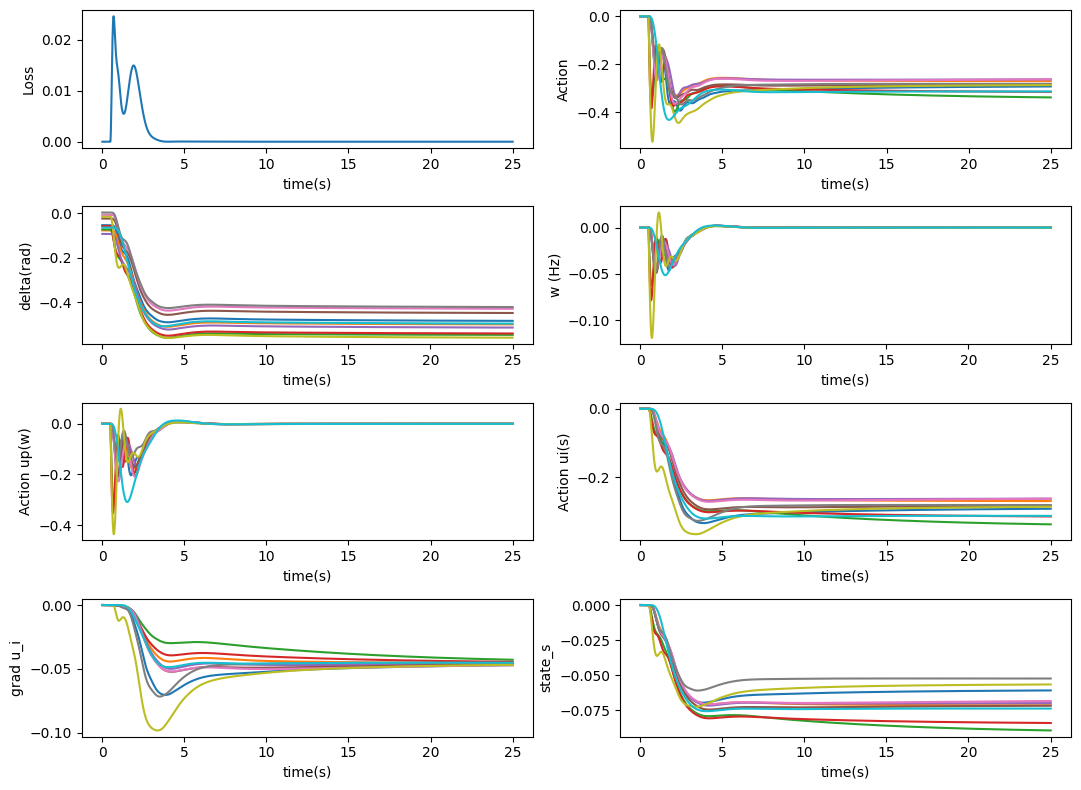

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

init_state=equilibrium_init

# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=2500
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):
    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()
    u, up, ui = Action_NNLinear(x, action_s, model_linear, env)

    action_s, next_x, r= env.step_PI_CommEdge(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:dim_action])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,dim_action:dim_action*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action up(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action ui(s)')
fig.tight_layout()    

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()    

### DenseNN-Comm

tf.Tensor([[1313.734]], shape=(1, 1), dtype=float32)


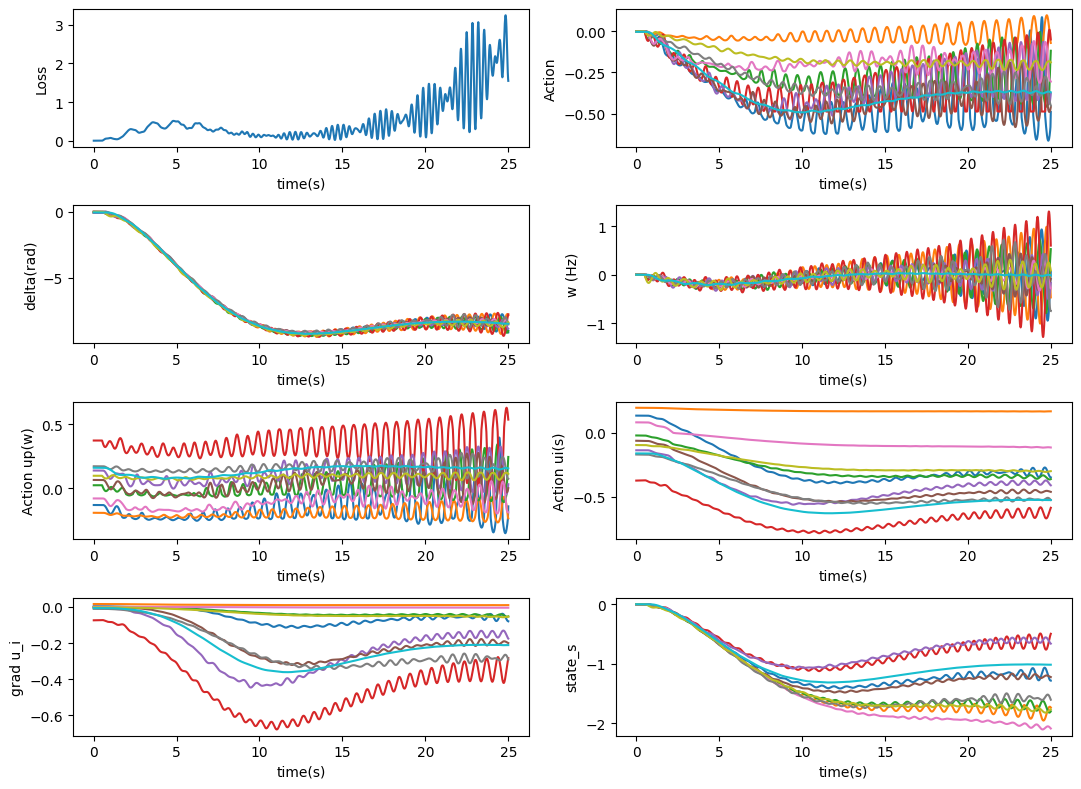

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

init_state=equilibrium_init


# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=2500
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]


Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):

    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()

    u, up, ui = Action_DenseNN(x, action_s, model_NN, env)

    action_s, next_x, r= env.step_PI_CommEdge(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:dim_action])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,dim_action:dim_action*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action up(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action ui(s)')
fig.tight_layout()    

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()    

### StableNN-WoComm

tf.Tensor([[1.3261689]], shape=(1, 1), dtype=float32)


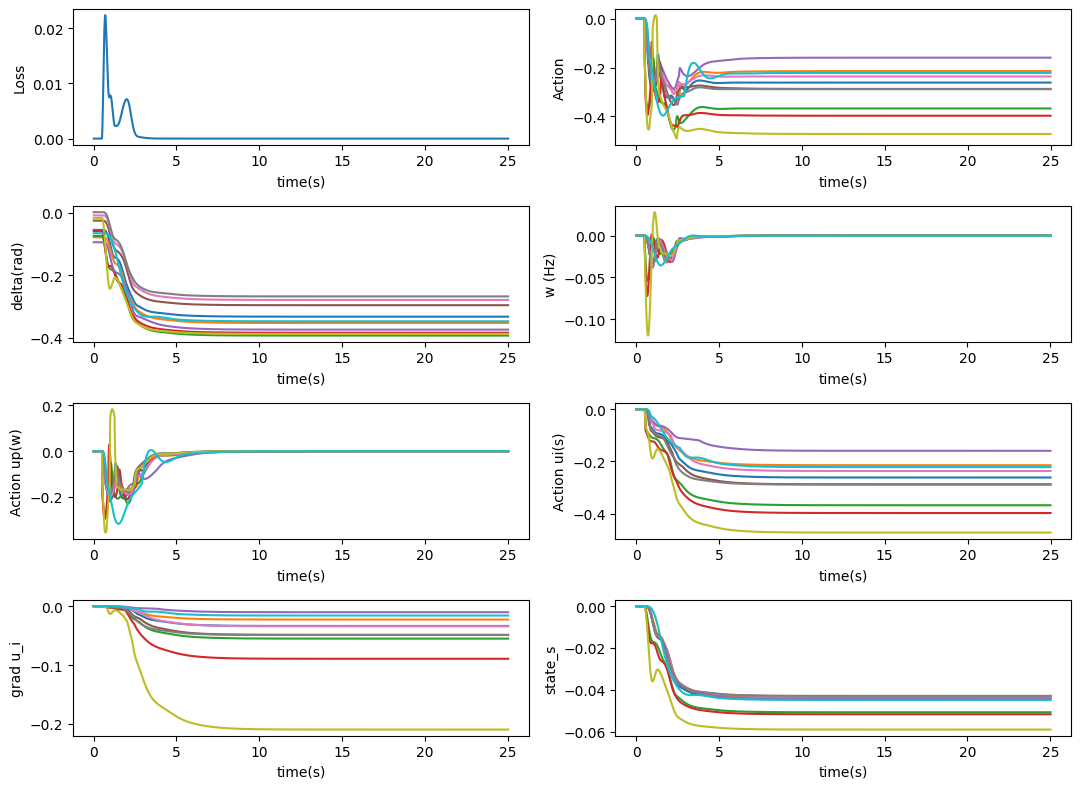

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

init_state=equilibrium_init


x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=2500
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):

    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()

    u, up, ui =Action(x, action_s, model_WoCost, env)

    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)
    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:dim_action])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,dim_action:dim_action*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action up(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action ui(s)')
fig.tight_layout()    

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()    